**Python 3.12.4**


Multiple sentiment classification approaches:
	•	Dictionary-based sentiment scoring
	•	TF-IDF + Logistic Regression
	•	RNN with randomly initialized embeddings
	•	RNN with pre-trained W2v embeddings
	•	DistilBERT (Huggingface pipeline)
	•	Fine-tuned DistilBERT using Trainer API

The dataset files (btc_tweets_train.parquet.gzip, btc_tweets_test.parquet.gzip) and the pretrained Word2Vec model w2v_imdb_full_d100_e500.model are assumed to be located in the same directory as this notebook.**Download link:**
https://drive.google.com/file/d/1J1edk-jyPsO0PCiY-NEFiRxo-PIYART3/view?usp=drive_link

In [ ]:
# === 1. Package Installation ===
!pip install pandas numpy pyarrow matplotlib seaborn scikit-learn nltk emoji unidecode transformers torch tf-keras tensorflow xgboost gensim pysentiment2 beautifulsoup4
!pip install 'accelerate>=0.26.0'

# === 2. NLTK Setup ===
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# === 3. Standard Libraries ===
import os
import re
import string
import html
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 4. Text Preprocessing ===
from bs4 import BeautifulSoup
import emoji
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# === 5. Dictionary-Based Sentiment Analysis ===
import pysentiment2 as ps
dc = ps.HIV4()

# === 6. Classical Machine Learning ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


# === 7. Keras / TensorFlow Deep Learning Models ===
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Dropout, Flatten, Bidirectional
from keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential as TFSequential
from tensorflow.keras.layers import Embedding as TFEmbedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, GRU, LSTM, Dense, Dropout

# === 8. Word Embeddings (Pre-trained) ===
from gensim.models import KeyedVectors
w2v_kv = KeyedVectors.load_word2vec_format("w2v_imdb_full_d100_e500.model", binary=False)


# === 9. Huggingface Transformers Setup ===
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from transformers import pipeline

## fine-tune for the Huggingface pipeline
!pip install pyarrow==12.0.1 --force-reinstall
!pip install datasets
from datasets import Dataset
from datasets import ClassLabel



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wanghaiyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wanghaiyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wanghaiyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/wanghaiyang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/wanghaiyang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


  Using cached pyarrow-12.0.1.tar.gz (1.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/c5/68/d3410e975bebbf5be00c1238d0418345d8ec5d88b7a6c102211a1c967edd/pyarrow-12.0.1.tar.gz (from https://pypi.org/simple/pyarrow/) (requires-python:>=3.7): Requested pyarrow==12.0.1 from https://files.pythonhosted.org/packages/c5/68/d3410e975bebbf5be00c1238d0418345d8ec5d88b7a6c102211a1c967edd/pyarrow-12.0.1.tar.gz has inconsistent version: expected '12.0.1', but metadata has '12.0.0'
ERROR: Could not find a version that satisfies the requirement pyarrow==12.0.1 (from versions: 0.9.0, 0.10.0, 0.11.0, 0.11.1, 0.12.0, 0.12.1, 0.13.0, 0.14.0, 0.15.1, 0.16.0, 0.17.0, 0.17.1, 1.0.0, 1.0.1, 2.0.0, 3.0.0, 4.0.0, 4.0.1, 5.0.0, 6.0.0, 6.0.1, 7.0.0, 8.0.0, 9.0.0, 10.0.0, 10.0.1, 11.0.0, 12.0.0, 12.0.1, 13.0.0, 14.0.0, 14.0.1, 14.0.2, 15.0.0, 15.0.1, 15.0.2, 16.0.0, 16.1.

In [ ]:
# Load Data

df_test= pd.read_parquet('btc_tweets_test.parquet.gzip')
print(df_test.head)
df_train = pd.read_parquet('btc_tweets_train.parquet.gzip')
print(df_train.head)
print(df_test.columns)

<bound method NDFrame.head of                                                               hashtags  \
tweet ID                                                                 
1641861708246552576                                      [crypto, btc]   
1641861783898972167                                 [Bitcoin, Bitcoin]   
1641862152532418562  [Giveaway, BTC, SolanaGiveaways, Giveaway, Air...   
1641862338369183753  [EOS, USDT, BTC, crypto, Bitcoin, etherium, Bi...   
1641862430434131968                        [BTC, ETH, BSC, GroveToken]   
...                                                                ...   
1641952735653421056                                          [Bitcoin]   
1641952895112290305                                          [Bitcoin]   
1641952949763973122                       [STAMPS, XCP, ORDINALS, BTC]   
1641953124981284864  [Bitcoin, Decentralization, blockchain, ChatGP...   
1641953216999968769      [Web3, BTC, blockchain, seer, cryptocurrency]   

       

In [3]:
print(df_train['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())

sentiment
True     1220
False     280
Name: count, dtype: int64
sentiment
True     404
False     96
Name: count, dtype: int64


In [4]:
# Utility Functions
##  Text Preprocessing Utility


class preprocess_text:
    """
    A clean, modular text preprocessor for web-scraped or informal social media text.
    Includes HTML, emoji, URL removal, lemmatization, and optional stopword filtering.
    """

    def __init__(self, remove_stopwords=True, lemmatize=True):
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean(self, text: str) -> str:
        # 1. Lowercase
        text = text.lower()

        # 2. Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()

        # 3. Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # 4. Remove emojis
        text = emoji.replace_emoji(text, replace='')

        # 5. Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # 6. Remove accents (e.g., é → e)
        text = unidecode(text)

        # 7. Remove hashtags and mentions
        text = re.sub(r'[@#]\w+', '', text)

        # 8. Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        # 9. Tokenize
        tokens = nltk.word_tokenize(text)

        # 10. Stopword removal
        if self.remove_stopwords:
            tokens = [word for word in tokens if word not in self.stop_words]

        # 11. Lemmatization
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        return ' '.join(tokens)


#  Evaluation Functions (Shared)

def assess_binary_classifier(ytest, yhat, cut_off=0.5, plot_roc=True):

    # Calculate discrete class predictions

    yhat_c = np.where(yhat>cut_off, 1, 0)

    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_c)
    auc = roc_auc_score(ytest, yhat)
    rec = recall_score (ytest, yhat_c)
    f1 = f1_score (ytest, yhat_c)
    prec = precision_score(ytest, yhat_c)

    # Confusion matrix
    cmat = confusion_matrix(ytest, yhat_c)

    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')
        plt.xlabel('False positive rate')
        plt.legend(loc='lower right')
        plt.show();

    return(auc, acc, cmat, prec, rec, f1)





# Dictionary & TF-IDF Baseline

def get_sentiment_score(text):
    score = round(dc.get_score(dc.tokenize(text))['Polarity'], 2)
    return score



def get_tfidf_vectorizer():
    def dummy_fun(doc):
        return doc
    return TfidfVectorizer(
        analyzer='word',
        tokenizer=dummy_fun,
        preprocessor=dummy_fun,
        token_pattern=None)



# RNN Model Builder
def build_bidirectional_rnn_classifier(
    vocab_size,
    embedding_dim,
    input_length,
    rnn_type='gru',
    hidden_units=16,
    learning_rate=0.001,
    embedding_weights=None,
    trainable_embedding=True
):
    """
    Build a Bidirectional GRU or LSTM sentiment classifier.

    Parameters:
    - vocab_size: int, size of vocabulary (NUM_WORDS)
    - embedding_dim: int, size of word embedding vectors
    - input_length: int, length of input sequences after padding
    - rnn_type: str, 'gru' or 'lstm'
    - hidden_units: int, number of hidden units in RNN layer
    - learning_rate: float, learning rate for optimizer

    Returns:
    - Compiled Keras model
    """
    model = Sequential()
    # Embedding
    if embedding_weights is not None:
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=input_length,
            embeddings_initializer=Constant(embedding_weights),
            trainable=trainable_embedding
        ))
    else:
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=input_length
        ))


    if rnn_type.lower() == 'gru':
        model.add(Bidirectional(GRU(hidden_units, activation='relu')))
    elif rnn_type.lower() == 'lstm':
        model.add(Bidirectional(LSTM(hidden_units, activation='relu')))
    else:
        raise ValueError("rnn_type must be either 'gru' or 'lstm'")

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model



# RNN Evaluation Function

def diag_nn(model, story, x_ts, y_ts, plot_roc=True, plot_loss=True):


    # Calculate test set predictions
    yhat = model.predict(x_ts).flatten()

    # Calling our helper for classifier evaluation
    auc, acc ,cmat ,prec, rec, f1 = assess_binary_classifier(y_ts, yhat, cut_off=0.5, plot_roc=plot_roc)
    print("NN test set performance:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))
    print('Confusion matrix:')
    print(cmat)

    if plot_loss:
        plt.plot(story.history['loss'])
        plt.plot(story.history['val_loss'])
        plt.title('loss evolution')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    return (auc, acc ,cmat, prec, rec, f1)

###Embedding Matrix Builder

def get_embedding_matrix(tokenizer, pretrain, vocab_size, verbose=0):


    dim = 0

    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))


    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))


    oov_words = []

    v = len(tokenizer.word_index)
    start = time.time()
    print('Start embedding process for {} words.'.format(v), flush=True)

    for word, i in tokenizer.word_index.items():
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
        # Some output that the method is still alive
        if i % 5000 == 0 and verbose>0:
            print('{}/{} words in {} sec'.format(i, v, (time.time()-start)), flush=True)


    print('Created embedding matrix of shape {} in {} min '.format(emb_mat.shape, (time.time()-start)/60))

    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)



# Huggingface Inference Pipeline



def pipeline_classify(data):

    labels = []
    scores = []
    for text in data:
        result = classifier(text, truncation=True)
        label = result[0]['label']
        score = result[0]['score']

        positive_prob = score if label.upper() == 'POSITIVE' else 1 - score
        labels.append(label)
        scores.append(positive_prob)
    return labels, scores


### Fine-tune DistilBERT


from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os

def fine_tune_distilbert(
    train_dataset,
    test_dataset,
    model_name="distilbert-base-uncased",
    num_labels=2,
    seed=42,
    num_train_epochs=1,
    train_batch_size=16,
    eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.0,
    output_dir="./results",
    logging_dir="./logs",
    return_trainer=True
):
    """
    Fine-tune a pre-trained DistilBERT model on binary sentiment classification task.

    Parameters:
    - train_dataset, test_dataset: tokenized Huggingface Dataset
    - model_name: huggingface model name
    - num_labels: number of output classes (2 for binary)
    - seed: random seed
    - num_train_epochs: training epochs
    - train_batch_size: training batch size
    - eval_batch_size: evaluation batch size
    - learning_rate: Adam learning rate
    - weight_decay: optional weight decay
    - output_dir: folder to save output (optional)
    - logging_dir: log folder (optional)
    - return_trainer: if True, return trainer + model; else only model

    Returns:
    - model (and optionally trainer)
    """

    # Disable wandb logs
    os.environ["WANDB_DISABLED"] = "true"

    # Load model
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

    # Define metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "precision": precision_score(labels, preds),
            "recall": recall_score(labels, preds),
            "f1": f1_score(labels, preds)
        }


    # Define training arguments (updated)
    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_dir=logging_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        
        logging_steps=10,
        seed=seed,
        report_to="none"
    )
    # Build trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    return (trainer, model) if return_trainer else model



In [5]:
#  data frame for the whole assessment
df_scores = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

In [6]:
#imbalance data
from sklearn.utils import class_weight

# compute class weight
y_train = df_train['sentiment'] # Moved this line here
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# convert to dictionary
class_weights = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)

{0: 2.6785714285714284, 1: 0.6147540983606558}


In [7]:
df_train['sentiment'] = df_train['sentiment'].astype(int)
df_test['sentiment'] = df_test['sentiment'].astype(int)

In [8]:
# preprocess the testing and training set
cleaner = preprocess_text()

df_train['clean_content'] = df_train['content'].apply(lambda x: cleaner.clean(x))
df_test['clean_content'] = df_test['content'].apply(lambda x: cleaner.clean(x))


#df_train['clean_content'] = df_train['content'].apply(preprocess_text)
#df_test['clean_content'] = df_test['content'].apply(preprocess_text)

/var/folders/7b/m_fkmvpn11j4t6w93zx70w680000gn/T/ipykernel_12208/3741683227.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/var/folders/7b/m_fkmvpn11j4t6w93zx70w680000gn/T/ipykernel_12208/3741683227.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [9]:


# Show original vs cleaned for test set
for i in range(20):
    print("==== Sample", i+1, "====")
    print("Original: ", df_test['content'].iloc[i])
    print("Cleaned : ", df_test['clean_content'].iloc[i])

# training set
for i in range(20):
    print("==== Sample", i+1, "====")
    print("Original: ", df_train['content'].iloc[i])
    print("Cleaned : ", df_train['clean_content'].iloc[i])

==== Sample 1 ====
Original:  #crypto $crypto #btc 
I am Chinese crypto alpha, although my English is not good, but I will try to send some English tweets!  Let me see if there are messages of support from foreign fans！
Cleaned :  crypto crypto btc chinese crypto alpha although english good try send english tweet let see message support foreign fan !
==== Sample 2 ====
Original:  #Bitcoin would have to fall another 80% to reach the lows of 3 years ago.

Rates have already skyrocketed, most crypto platforms (including FTX) died, and sentiment is dead as most think it’s over.

Even if #Bitcoin falls 50% to $14k new lows (which I doubt), this is remarkable.
Cleaned :  bitcoin would fall another 80 reach low 3 year ago rate already skyrocketed crypto platform including ftx died sentiment dead think 's even bitcoin fall 50 14k new low doubt remarkable
==== Sample 3 ====
Original:  #Giveaway $1000 Matic in 3Days

🏆To win
1️⃣ Follow  @matic
2️⃣ Like &amp; RT
3️⃣ Tag 3 Friends 

#BTC  #SolanaG

In [10]:
# sentiment dictionary prediction

df_train['sentiment_score'] = df_train['clean_content'].apply(get_sentiment_score)
df_test['sentiment_score'] = df_test['clean_content'].apply(get_sentiment_score)


In [11]:
# Assess lexicon-based sentiment classifier
ytest = df_train['sentiment']
yhat = df_train['sentiment_score']
auc_dict, acc_dict, cmat_dict, prec_dict, rec_dict, f1_dict = assess_binary_classifier(ytest=df_train['sentiment'], yhat=df_train['sentiment_score'],plot_roc=False ,cut_off=0)


From the confusion matrxix , we can easily get the following information
the model predicted positive sentiment, but the actual sentiment was negative(type I error)
True positive sentiment when the actual sentiment was also positive

In [12]:
# assesment relusts for the sentiment analysis;
df_scores['sentiment_dictionary'] = [acc_dict, prec_dict, rec_dict, f1_dict, auc_dict]
print(df_scores)


           sentiment_dictionary
Accuracy               0.554667
Precision              0.878082
Recall                 0.525410
F1                     0.657436
AUC                    0.661705


the second model: TFIDF_XGBoost
frequency_based features

In [13]:
# TFIDF_XGBoost
tfidf_vectorizer = get_tfidf_vectorizer()
#TFIDF Feature Extraction:
reviews_clean_tfidf_tr = tfidf_vectorizer.fit_transform(df_train['clean_content']) #
reviews_clean_tfidf_ts = tfidf_vectorizer.transform(df_test['clean_content'])

## training the XGBoost
y_train = df_train['sentiment']
scale_pos_weight = len(y_train[y_train == False]) / len(y_train[y_train == True])
xgbc = XGBClassifier(n_estimators=200, random_state=42,scale_pos_weight =scale_pos_weight)

xgbc.fit(reviews_clean_tfidf_tr,y_train)
xgbc_tfidf_discrete_pr=xgbc.predict(reviews_clean_tfidf_ts)
xgbc_tfidf_proba_pr=xgbc.predict_proba(reviews_clean_tfidf_ts)[:,1]

In [14]:
y_train = df_train['sentiment'].astype(int)

In [15]:
#Assessment of TF_IDF_XGBoost

y_test = df_test['sentiment']
yhat_proba_xgb = xgbc_tfidf_proba_pr


auc_xgb, acc_xgb, cmat_xgb, prec_xgb, rec_xgb, f1_xgb = assess_binary_classifier(
    ytest=y_test,
    yhat=yhat_proba_xgb,
    cut_off=0.5,
    plot_roc=False
)

df_scores['TF-IDF_XGBoost'] = [acc_xgb, prec_xgb, rec_xgb, f1_xgb, auc_xgb]
print(df_scores)

           sentiment_dictionary  TF-IDF_XGBoost
Accuracy               0.554667        0.746000
Precision              0.878082        0.821346
Recall                 0.525410        0.876238
F1                     0.657436        0.847904
AUC                    0.661705        0.614222


Model 3: RNN classifer with LSTM


In [16]:
# Tokenizer setup
NUM_WORDS = 4000
tok = Tokenizer(num_words=NUM_WORDS, oov_token=1)
tok.fit_on_texts(df_train['clean_content'])  # 只对训练集拟合

# Convert texts to integer sequences
X_tr_int = tok.texts_to_sequences(df_train['clean_content'])
X_ts_int = tok.texts_to_sequences(df_test['clean_content'])

#  Set max review length
MAX_REVIEW_LENGTH = max(len(seq) for seq in X_tr_int)  # 或手动设为 44
print(f"The longest review has {MAX_REVIEW_LENGTH} words.")

# Pad sequences to the same length
X_tr_int_pad = pad_sequences(X_tr_int, maxlen=MAX_REVIEW_LENGTH)
X_ts_int_pad = pad_sequences(X_ts_int, maxlen=MAX_REVIEW_LENGTH)


The longest review has 44 words.


In [17]:
# Define hyperparameters
NB_HIDDEN = 16
EPOCH = 5
BATCH_SIZE = 64
EMBEDDING_DIM = 50
VAL_SPLIT = 0.25
LEARNING_RATE = 0.001

# Build the GRU model using the modular wrapper
bi_gru = build_bidirectional_rnn_classifier(
    vocab_size=NUM_WORDS,
    embedding_dim=EMBEDDING_DIM,
    input_length=MAX_REVIEW_LENGTH,
    rnn_type='gru',
    hidden_units=NB_HIDDEN,
    learning_rate=LEARNING_RATE
)

# fitting the model
story = bi_gru.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT,verbose=1,
                   class_weight=class_weights)


# Assess the performance of the FFN
acc_bigru, prec_bigru,camt_bigru, rec_bigru, f1_bigru, auc_bigru  = diag_nn(bi_gru, story, X_ts_int_pad, y_test, plot_roc=False, plot_loss=False)

# Add results to our data frame to keep track of results
df_scores['BiRNN_GRU'] = [acc_bigru, prec_bigru, rec_bigru, f1_bigru, auc_bigru]



Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8394 - loss: 0.6534 - val_accuracy: 0.7520 - val_loss: 0.6659
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8335 - loss: 0.6546 - val_accuracy: 0.7520 - val_loss: 0.6545
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8345 - loss: 0.6402 - val_accuracy: 0.7520 - val_loss: 0.6347
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8373 - loss: 0.6231 - val_accuracy: 0.7493 - val_loss: 0.5926
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9220 - loss: 0.5436 - val_accuracy: 0.7627 - val_loss: 0.5132
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
NN test set performance:	AUC=0.7185	Accuracy=0.8040
Confusion matrix:
[[ 14  82]
 [ 16 388]]


Model 4: RNN classifer with Bidirectional LSTM



In [19]:
# Create embedding weight matrix
imdb_index = w2v_kv
imdb_embeddings, _ = get_embedding_matrix(tok, imdb_index, NUM_WORDS)


# hyperparameter setting
NB_HIDDEN = 16
EPOCH = 5
BATCH_SIZE = 64
EMBEDDING_DIM = 100  # Changed to 100 to match pre-trained embedding dimension
VAL_SPLIT = 0.25

# Model 
model_lstm = build_bidirectional_rnn_classifier(
    vocab_size=NUM_WORDS,
    embedding_dim=EMBEDDING_DIM,
    input_length=MAX_REVIEW_LENGTH,
    rnn_type='lstm',
    hidden_units=NB_HIDDEN,
    learning_rate=0.001,
    embedding_weights=imdb_embeddings,  # Pass the pre-trained embeddings
    trainable_embedding=True

)

# Training
RNN_lstm = model_lstm.fit(
    X_tr_int_pad,          # padded train sequences
    y_train,           # labels
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=VAL_SPLIT,
    verbose=1,
    class_weight=class_weights
)


# Assess the performance of the FFN
acc_bilstm, prec_bilstm,camt_bilstm, rec_bilstm, f1_bilstm, auc_bilstm  = diag_nn(model_lstm, RNN_lstm, X_ts_int_pad, y_test, plot_roc=False, plot_loss=False)

# Add results to our data frame to keep track of results
df_scores['BiRNN_LSTM'] = [acc_bilstm, prec_bilstm, rec_bilstm, f1_bilstm, auc_bilstm]



Start embedding process for 6555 words.
Created embedding matrix of shape (4000, 100) in 0.00017738739649454752 min 
Encountered 4483 out-of-vocabulary words.
Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5368 - loss: 0.7696 - val_accuracy: 0.5173 - val_loss: 0.7371
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5242 - loss: 0.6641 - val_accuracy: 0.5547 - val_loss: 0.7127
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6710 - loss: 0.6088 - val_accuracy: 0.6133 - val_loss: 0.6841
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7336 - loss: 0.5841 - val_accuracy: 0.6427 - val_loss: 0.6829
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8027 - loss: 0.5109 - val_accuracy: 0.6613 - val_loss: 0.6393
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
NN test set performance:	AUC=0.5450	Accuracy=0.6500
Confusion matrix:
[[ 33  63]
 [112 292]]


Model 5. Pre-trained transformer model(huggingface pipelines)

In [20]:
df_train['sentiment'] = df_train['sentiment'].astype(int)
df_test['sentiment'] = df_test['sentiment'].astype(int)

classifier = pipeline('sentiment-analysis', model='distilbert/distilbert-base-uncased-finetuned-sst-2-english',
                      torch_dtype=None) # Removed device=-1

Device set to use mps:0


In [ ]:
#  Huggingface pipeline prediction
labels_test, probs_test = pipeline_classify(df_test['clean_content'].tolist())

# store df_test
df_test['pipeline_label'] = labels_test
df_test['pipeline_prob'] = probs_test


y_true = df_test['sentiment']
y_score = df_test['pipeline_prob']


auc_hugging, acc_hugging, cmat_hugging, prec_hugging, rec_hugging, f1_hugging = assess_binary_classifier(
    ytest = y_true,
    yhat = y_score,
    cut_off=0.5,
    plot_roc=False
)
#  df_scores
df_scores['Huggingface_pipeline'] = [acc_hugging, prec_hugging, rec_hugging, f1_hugging, auc_hugging]



Model 6. Fine-tune a pre-trained transformer model

In [22]:
# 
df_pos = df_train[df_train['sentiment'] == 1]
df_neg = df_train[df_train['sentiment'] == 0]

df_pos_sampled = df_pos.sample(n=len(df_neg), random_state=42)
df_balanced = pd.concat([df_neg, df_pos_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# convert to Huggingface Dataset format
train_data = df_balanced[['clean_content', 'sentiment']].rename(columns={'clean_content': 'text', 'sentiment': 'label'})
test_data = df_test[['clean_content', 'sentiment']].rename(columns={'clean_content': 'text', 'sentiment': 'label'})

train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)


#tokenizer + map

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    tokens = tokenizer(batch['text'], truncation=True, padding="max_length", max_length=44)
    tokens["label"] = batch["label"]  # 显式保留标签
    return tokens

train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)


class_label = ClassLabel(num_classes=2, names=["negative", "positive"])

train_tokenized = train_tokenized.cast_column("label", class_label)
test_tokenized = test_tokenized.cast_column("label", class_label)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/560 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.686100
20,0.667800
30,0.598700
40,0.520400
50,0.424000
60,0.344700
70,0.408000
80,0.258200
90,0.238900
100,0.231300


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


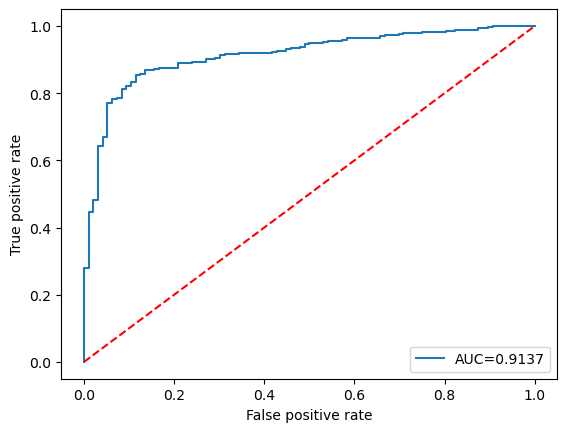

In [ ]:
# Call the fine-tuning function
trainer, model = fine_tune_distilbert(
    train_dataset=train_tokenized,
    test_dataset=test_tokenized,
    num_train_epochs=2
)
#prediction on test set
predictions = trainer.predict(test_tokenized)
probs = predictions.predictions
y_pred_prob = probs[:, 1] 
 
#Evaluate using custom evaluation function
auc_bert, acc_bert, cmat_bert, prec_bert, rec_bert, f1_bert = assess_binary_classifier(
    ytest = df_test['sentiment'], 
    yhat = y_pred_prob,
    cut_off = 0.5,
    plot_roc=False
)

# Store results into the summary table
df_scores['DistilBERT_finetuned'] = [acc_bert, prec_bert, rec_bert, f1_bert, auc_bert]



In [ ]:
print(df_scores)

           sentiment_dictionary  TF-IDF_XGBoost  BiRNN_GRU  BiRNN_LSTM  \
Accuracy               0.554667        0.746000   0.715011    0.610174   
Precision              0.878082        0.821346   0.794000    0.680000   
Recall                 0.525410        0.876238   0.838202    0.838889   
F1                     0.657436        0.847904   0.923267    0.747525   
AUC                    0.661705        0.614222   0.878681    0.790576   

           Huggingface_pipeline  DistilBERT_finetuned  
Accuracy               0.398000              0.722000  
Precision              0.981308              0.985348  
Recall                 0.259901              0.665842  
F1                     0.410959              0.794682  
AUC                    0.762144              0.913676  


In [ ]:
#           sentiment_dictionary  TF-IDF_XGBoost  BiRNN_GRU  BiRNN_LSTM  \
#Accuracy               0.554667        0.746000   0.715011    0.610174   
#Precision              0.878082        0.821346   0.794000    0.680000   
#Recall                 0.525410        0.876238   0.838202    0.838889   
#F1                     0.657436        0.847904   0.923267    0.747525   
#AUC                    0.661705        0.614222   0.878681    0.790576   

#           Huggingface_pipeline  DistilBERT_finetuned  
#Accuracy               0.398000              0.722000  
#Precision              0.981308              0.985348  
#Recall                 0.259901              0.665842  
#F1                     0.410959              0.794682  
#AUC                    0.762144              0.913676

In [1]:
!pip freeze > requirements.txt